<a href="https://colab.research.google.com/github/bluepsm/time-series-forecasting/blob/main/time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting
**Objective:** Predict future values of a time series (e.g., stock prices, weather data).

**Skills:** Time series analysis, ARIMA models, LSTM networks, feature engineering for time series.

# Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import itertools
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, pacf, acf
!pip install arm-mango
from mango import scheduler, Tuner
!pip install pmdarima
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Electric Production

In [2]:
#@title Import Dataset

dataset_electric = pd.read_csv('/content/drive/MyDrive/datasets/time-series/Electric_Production.csv')

In [3]:
#@title Parse Date of Dataset

dataset_electric.index = pd.to_datetime(dataset_electric['DATE'], format='%m/%d/%Y')
dataset_electric.index = pd.DatetimeIndex(dataset_electric.index.values, freq=dataset_electric.index.inferred_freq)
dataset_electric.drop('DATE', axis=1, inplace=True)

In [4]:
#@title Split Dataset

train_electric = dataset_electric[dataset_electric.index < '2016-01-01']
test_electric = dataset_electric[dataset_electric.index >= '2016-01-01']

## Analyzing Data

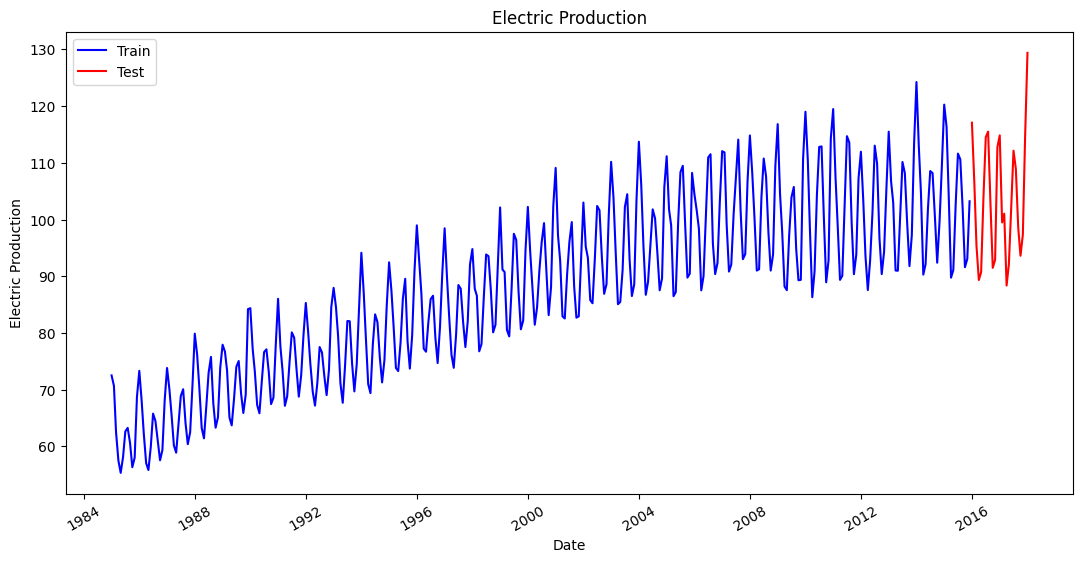

In [5]:
#@title Plotting Base Graph

plt.figure(figsize=(13, 6))
plt.plot(train_electric, color='blue')
plt.plot(test_electric, color='red')
plt.legend(['Train', 'Test'])
plt.xlabel('Date')
plt.ylabel('Electric Production')
plt.xticks(rotation=30)
plt.title('Electric Production')
plt.show()

In [6]:
#@title Checking ADF Statistic

electric_statistic = adfuller(dataset_electric['IPG2211A2N'])
print('ADF Statistic:', electric_statistic[0])
print('p-value:', electric_statistic[1])

ADF Statistic: -2.256990350047235
p-value: 0.1862146911658712


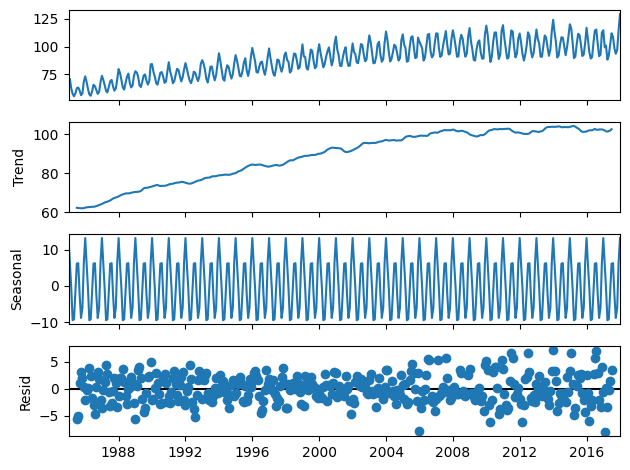

In [7]:
#@title Seasonal Decomposing

electric_seasonal_decompose = seasonal_decompose(dataset_electric, model='additive', period=12)
electric_seasonal_decompose.plot()
plt.show()

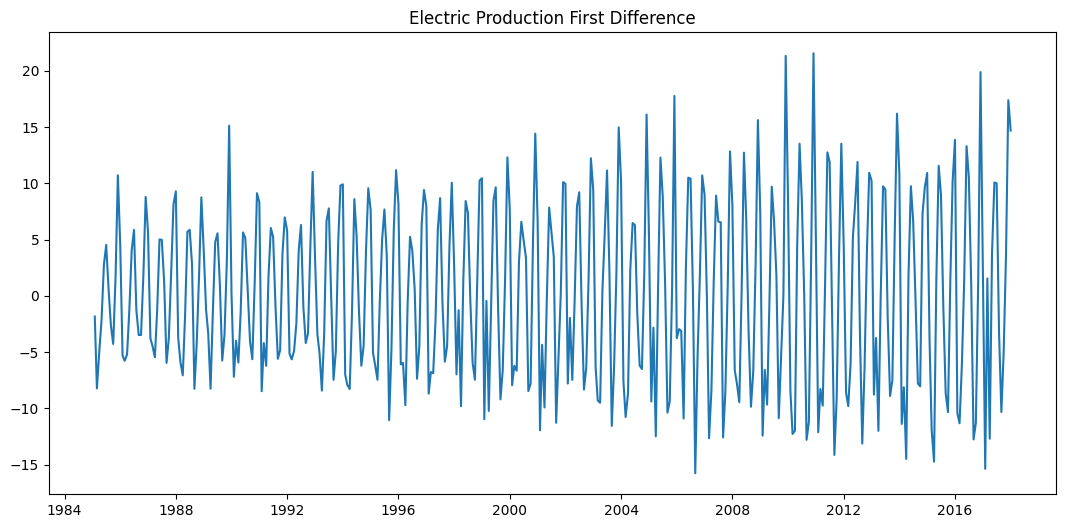

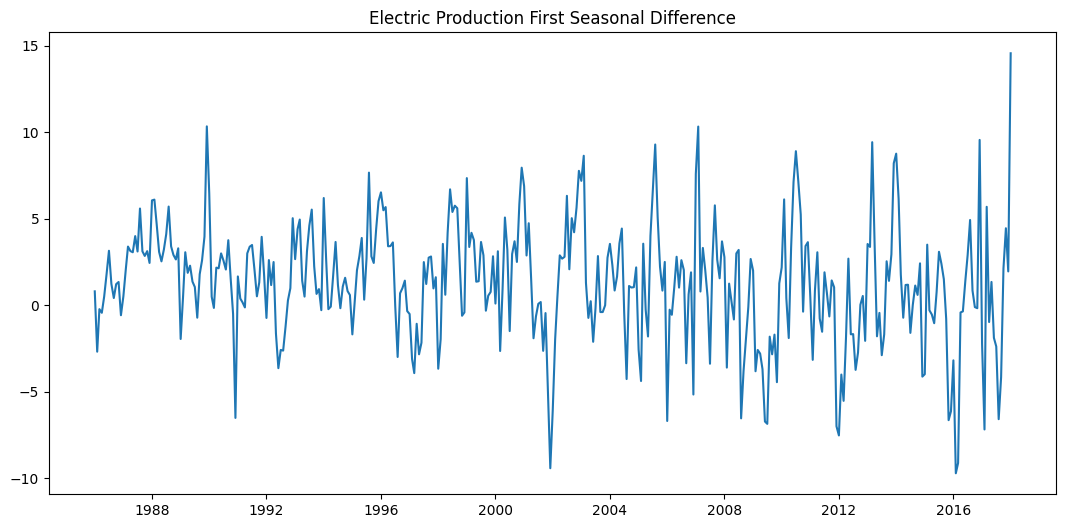

In [8]:
#@title Data Differencing

#First differencing
electric_first_diff = dataset_electric.diff().dropna()
plt.figure(figsize=(13, 6))
plt.plot(electric_first_diff)
plt.title('Electric Production First Difference')
plt.show()

#Seasonal first differecing
electric_first_seasonal_diff = dataset_electric.diff(periods=12).dropna()
plt.figure(figsize=(13, 6))
plt.plot(electric_first_seasonal_diff)
plt.title('Electric Production First Seasonal Difference')
plt.show()

In [9]:
#@title Checking ADF Statistic After Differencing

# electric_statistic = adfuller(electric_first_diff)
# print('ADF Statistic:', electric_statistic[0])
# print('p-value:', electric_statistic[1])

The result show that dataset is non-stationary (p-value is not less than 0.05) and it have seasonal look from seasonal graph.

After differencing it still non-stationary, so I will using SARIMA Model.

## SARIMA Model

In [10]:
#@title Building Model

electric_sarima = SARIMAX(train_electric, order=(4, 1, 4), seasonal_order=(2, 2, 2, 12))
# electric_sarima = SARIMAX(train_electric, order=(2, 1, 2), seasonal_order=(1, 1, 2, 6))
electric_sarima = electric_sarima.fit(maxiter=30000)

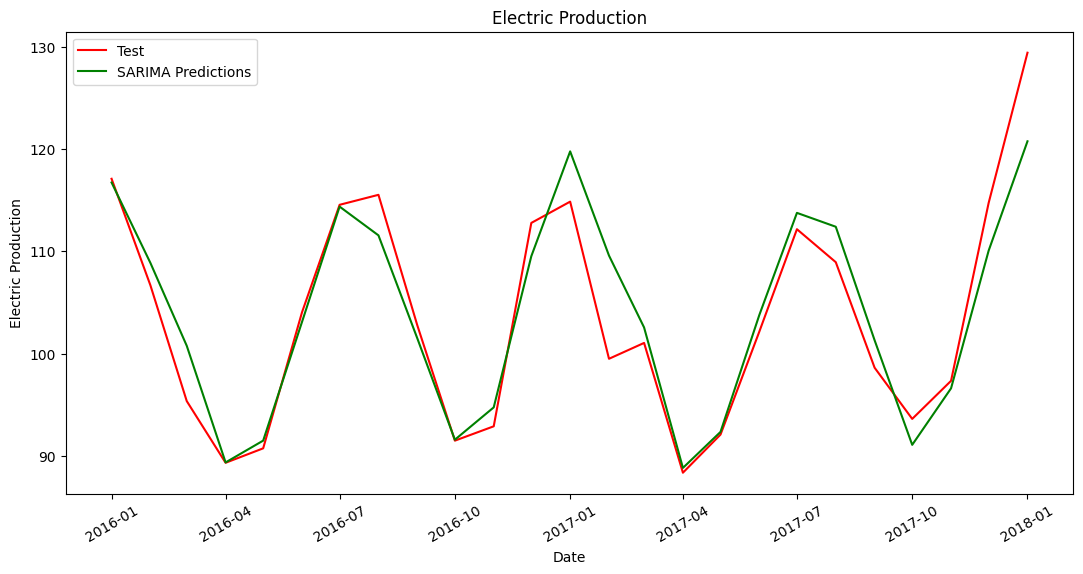

In [11]:
#@title Prediction

pred_electric_sarima = electric_sarima.get_forecast(steps=len(test_electric.index))
pred_electric_sarima_df = pred_electric_sarima.conf_int(alpha=0.05)
pred_electric_sarima_df['Predictions'] = electric_sarima.predict(start=pred_electric_sarima_df.index[0], end=pred_electric_sarima_df.index[-1])
pred_electric_sarima_df.index = test_electric.index

plt.figure(figsize=(13, 6))
# plt.plot(train_electric, color='blue')
plt.plot(test_electric, color='red')
plt.plot(pred_electric_sarima_df['Predictions'], color='green')
plt.legend(['Test', 'SARIMA Predictions'])
# plt.legend(['Train', 'Test', 'SARIMA Predictions'])
plt.xlabel('Date')
plt.ylabel('Electric Production')
plt.xticks(rotation=30)
plt.title('Electric Production')
plt.show()

In [12]:
#@title Evaluate

electric_sarima_rmse = np.sqrt(mean_squared_error(test_electric['IPG2211A2N'], pred_electric_sarima_df['Predictions']))
print('SARIMA MODEL RMSE:', electric_sarima_rmse)

SARIMA MODEL RMSE: 3.596938578504228


# Monthly Beer Production

In [23]:
#@title Import Dataset

dataset_beer = pd.read_csv('/content/drive/MyDrive/datasets/time-series/monthly-beer-production-in-austr.csv')

In [24]:
#@title Parse Date of Dataset

dataset_beer.index = pd.to_datetime(dataset_beer['Month'], format='%Y-%m')
dataset_beer.index = pd.DatetimeIndex(dataset_beer.index.values, freq=dataset_beer.index.inferred_freq)
dataset_beer.drop('Month', axis=1, inplace=True)

In [25]:
#@title Split Dataset

train_beer = dataset_beer[dataset_beer.index < '1994-01-01']
test_beer = dataset_beer[dataset_beer.index >= '1994-01-01']

## Analyzing Data

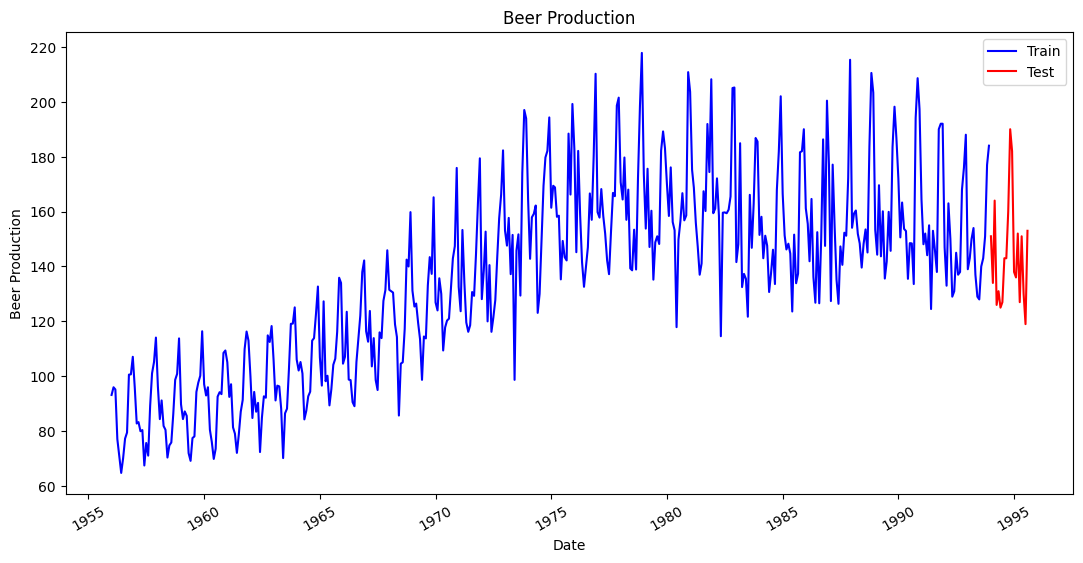

In [26]:
#@title Plotting Base Graph

plt.figure(figsize=(13, 6))
plt.plot(train_beer, color='blue')
plt.plot(test_beer, color='red')
plt.legend(['Train', 'Test'])
plt.xlabel('Date')
plt.ylabel('Beer Production')
plt.xticks(rotation=30)
plt.title('Beer Production')
plt.show()

In [27]:
#@title Checking ADF Statistic

beer_statistic = adfuller(dataset_beer['Monthly beer production'])
print('ADF Statistic:', beer_statistic[0])
print('p-value:', beer_statistic[1])

ADF Statistic: -2.282661418787577
p-value: 0.17762099829132505


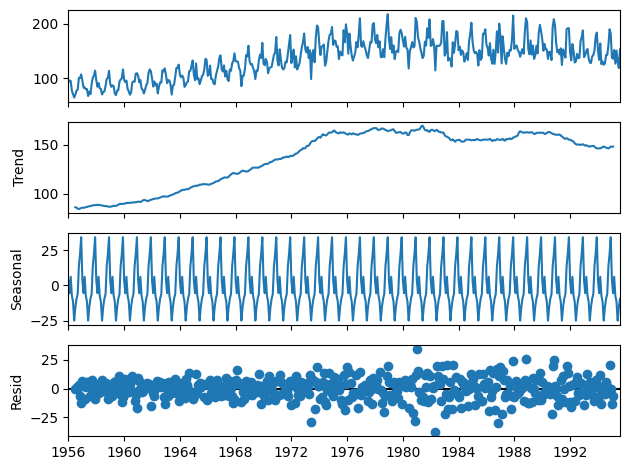

In [28]:
#@title Seasonal Decomposing

beer_seasonal_decompose = seasonal_decompose(dataset_beer, model='additive', period=12)
beer_seasonal_decompose.plot()
plt.show()

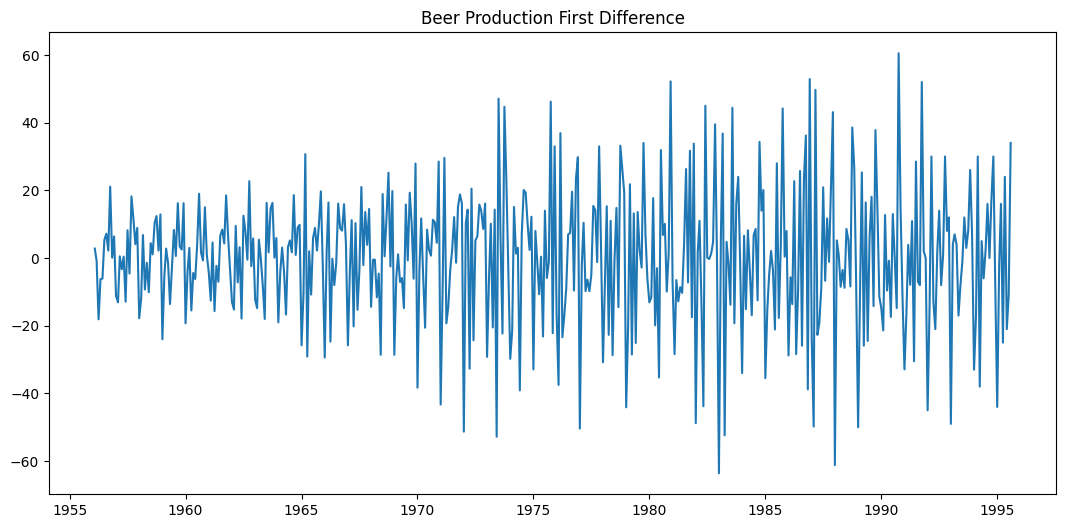

ADF Statistic: -4.980663743064638
p-value: 2.4234117859977578e-05


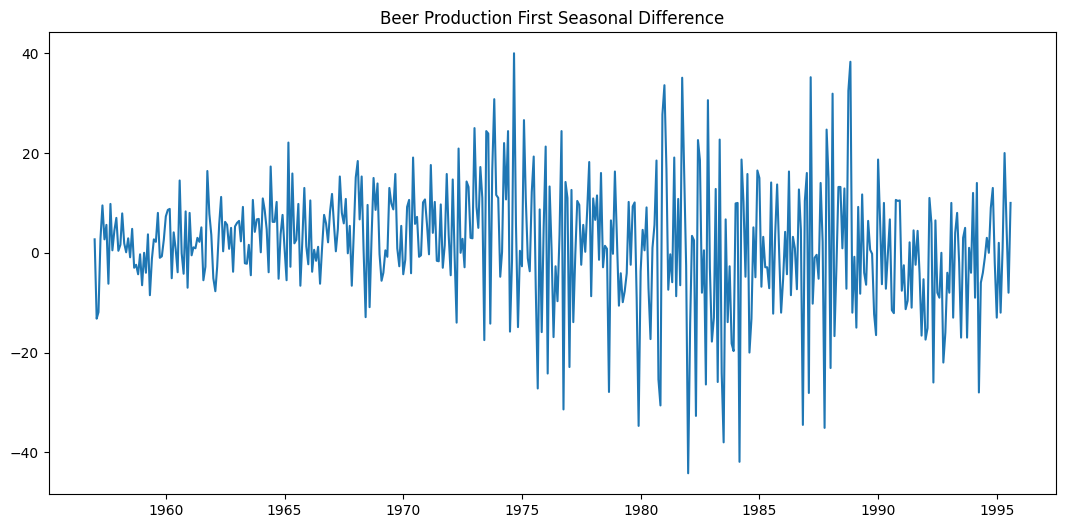

ADF Statistic: -2.896762477752007
p-value: 0.045725774623596484


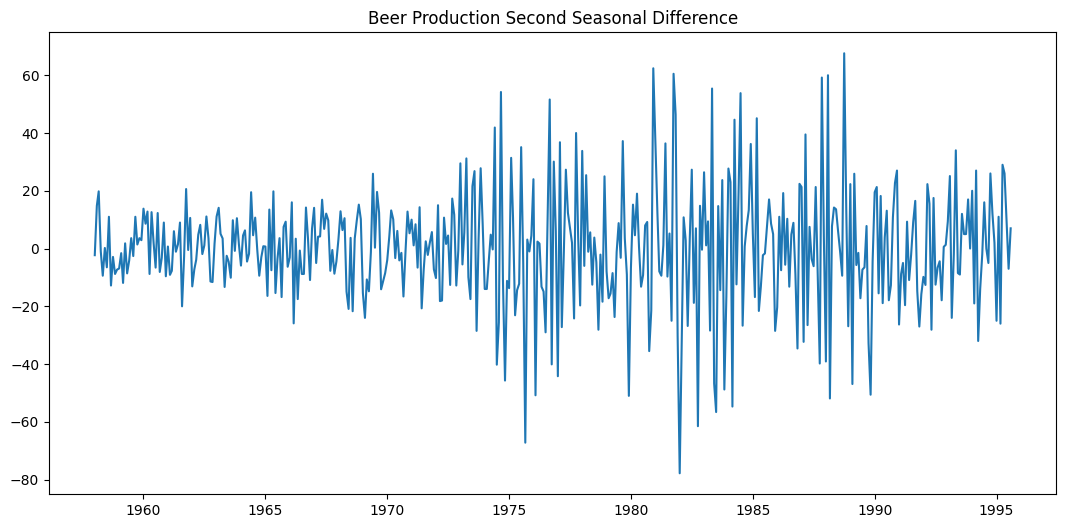

ADF Statistic: -5.4650168557285825
p-value: 2.469942740751976e-06


In [29]:
#@title Data Differencing

#First differencing
beer_first_diff = dataset_beer.diff().dropna()
plt.figure(figsize=(13, 6))
plt.plot(beer_first_diff)
plt.title('Beer Production First Difference')
plt.show()

beer_first_diff_statistic = adfuller(beer_first_diff)
print('ADF Statistic:', beer_first_diff_statistic[0])
print('p-value:', beer_first_diff_statistic[1])

#Seasonal differencing
beer_first_seasonal_diff = dataset_beer.diff(periods=12).dropna()
plt.figure(figsize=(13, 6))
plt.plot(beer_first_seasonal_diff)
plt.title('Beer Production First Seasonal Difference')
plt.show()

beer_first_seasonal_diff_statistic = adfuller(beer_first_seasonal_diff)
print('ADF Statistic:', beer_first_seasonal_diff_statistic[0])
print('p-value:', beer_first_seasonal_diff_statistic[1])

#Second seasonal differencing
beer_second_seasonal_diff = beer_first_seasonal_diff.diff(periods=12).dropna()
plt.figure(figsize=(13, 6))
plt.plot(beer_second_seasonal_diff)
plt.title('Beer Production Second Seasonal Difference')
plt.show()

beer_second_seasonal_diff_statistic = adfuller(beer_second_seasonal_diff)
print('ADF Statistic:', beer_second_seasonal_diff_statistic[0])
print('p-value:', beer_second_seasonal_diff_statistic[1])

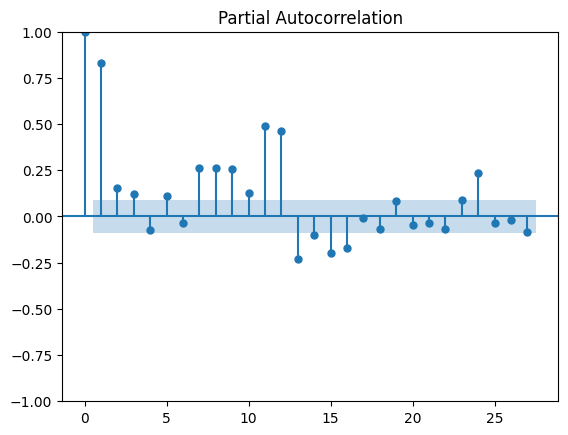

p =  3


In [30]:
#@title Plotting PACF

plot_pacf(dataset_beer)
plt.show()

beer_pacf_df = pacf(dataset_beer)

for i in range(0, len(beer_pacf_df)):
  if beer_pacf_df[i] < 1.96 / np.sqrt(len(dataset_beer)):
    print('p = ', i - 1)
    break

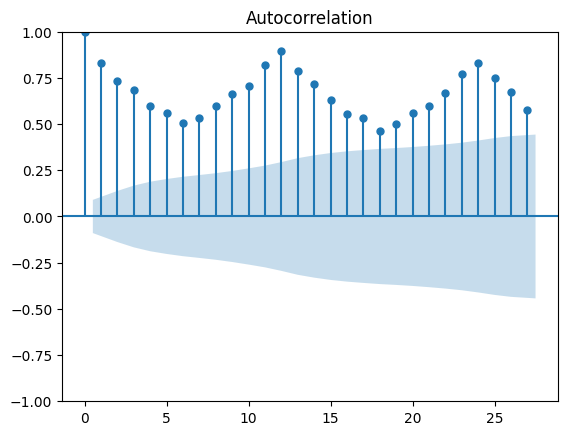

In [31]:
#@title Plotting ACF

plot_acf(dataset_beer, fft=True)
plt.show()

beer_acf_df = acf(dataset_beer, fft=True)

for i in range(0, len(beer_acf_df)):
  if beer_acf_df[i] < 1.96 / np.sqrt(len(dataset_beer)):
    print('p= ', i - 1)
    break

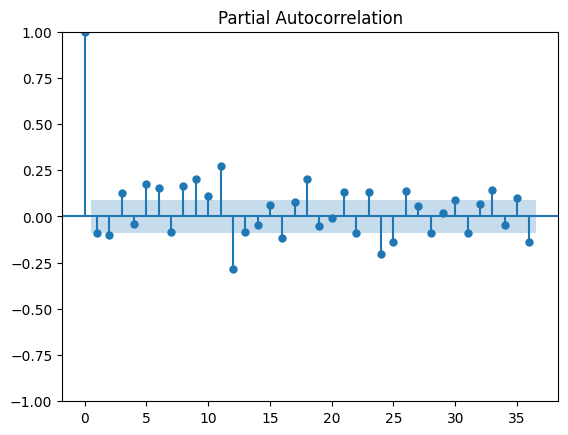

In [32]:
#@title Plotting Seasonal PACF

plot_pacf(beer_first_seasonal_diff, lags=36)
plt.show()

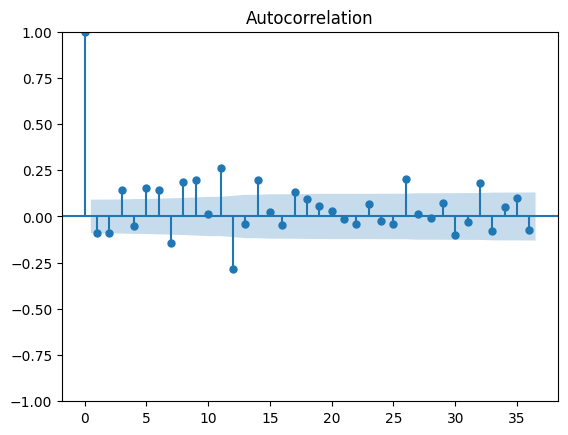

In [33]:
#@title Plotting Seasonal ACF

plot_acf(beer_first_seasonal_diff, lags=36)
plt.show()

In [34]:
#@title Find Appropriate MA(q)

# p = [3]
# d = range(1, 3)
# q = range(0, 5)
# pdq = list(itertools.product(p, d, q))

# aic = []

# for param in pdq:
#   try:
#     model = ARIMA(train_beer, order=param)
#     results = model.fit()
#     print('Order = {}'.format(param))
#     print('AIC = {}'.format(results.aic))
#     a = 'Order: ' + str(param) + ' AIC: ' + str(results.aic)
#     aic.append(a)
#   except:
#     continue

# def sarima_objective_function(args_list):
#   params_evaluated = []
#   results = []

#   for params in args_list:
#     try:
#       p, d, q = params['p'], params['d'], params['q']
#       P, D, Q, S = params['P'], params['D'], params['Q'], params['S']
#       trend = params['trend']

#       model = SARIMAX(train_beer, order=(p, d, q), seasonal_order=(P, D, Q, S), trend=trend)
#       predictions = model.fit()

#       rmse = np.sqrt(mean_squared_error(train_temperature, predictions.fittedvalues))
#       params_evaluated.append(params)
#       results.append(rmse)
#     except:
#       #print(f"Exception raised for {params}")
#       #pass
#       params_evaluated.append(params)
#       results.append(1e5)

#       #print(params_evaluated, rmse)
#   return params_evaluated, results

# param_space = dict(
#   p = [3],
#   d = range(0, 3),
#   q = range(1, 4),
#   P = range(1, 4),
#   D = range(0, 3),
#   Q = range(1, 4),
#   S = [12],
#   trend = ['n', 'c', 't', 'ct']
# )

# conf_Dict = dict()
# conf_Dict['num_iteration'] = 200
# data_values = list(train_beer['Monthly beer production'])
# tuner = Tuner(param_space, sarima_objective_function, conf_Dict)
# results = tuner.minimize()
# print('best parameters:', results['best_params'])
# print('best loss:', results['best_objective'])

In [35]:
#@title Find Appropriate Seasonal Orders

# P = range(1, 4)
# D = range(0, 3)
# Q = range(1, 4)
# S = [12]
# PDQS = list(itertools.product(P, D, Q, S))

# aic = []

# for param in PDQS:
#   try:
#     model = ARIMA(train_beer, order=(3, 1, 3), seasonal_order=param)
#     results = model.fit()
#     print('Seasonal Order = {}'.format(param))
#     print('AIC = {}'.format(results.aic))
#     a = 'Order: ' + str(param) + ' AIC: ' + str(results.aic)
#     aic.append(a)
#   except:
#     continue

The result show that dataset is non-stationary (p-value is not less than 0.05) and it have seasonal look from seasonal graph.

After differencing it still non-stationary, so I will using SARIMA Model.

## SARIMA Model

In [36]:
#@title Building Model

# beer_sarima = SARIMAX(train_beer, order=(3, 1, 3), seasonal_order=(1, 1, 2, 12))
beer_sarima = SARIMAX(train_beer, order=(2, 1, 1), seasonal_order=(4, 0, 3, 12))
beer_sarima = beer_sarima.fit()

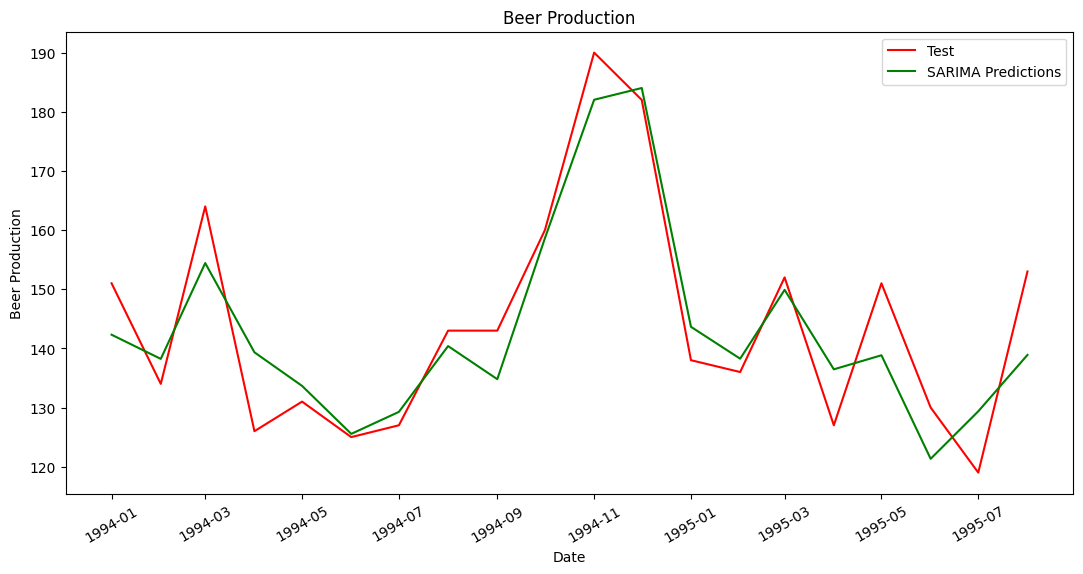

In [37]:
#@title Prediction

pred_beer_sarima = beer_sarima.get_forecast(steps=len(test_beer.index))
pred_beer_sarima_df = pred_beer_sarima.conf_int(alpha=0.05)
pred_beer_sarima_df['Predictions'] = beer_sarima.predict(start=pred_beer_sarima_df.index[0], end=pred_beer_sarima_df.index[-1])
pred_beer_sarima_df.index = test_beer.index

plt.figure(figsize=(13, 6))
# plt.plot(train_beer, color='blue')
plt.plot(test_beer, color='red')
plt.plot(pred_beer_sarima_df['Predictions'], color='green')
plt.legend(['Test', 'SARIMA Predictions'])
# plt.legend(['Train', 'Test', 'SARIMA Predictions'])
plt.xlabel('Date')
plt.ylabel('Beer Production')
plt.xticks(rotation=30)
plt.title('Beer Production')
plt.show()

In [38]:
#@title Evaluate

beer_sarima_rmse = np.sqrt(mean_squared_error(test_beer['Monthly beer production'], pred_beer_sarima_df['Predictions']))
print('SARIMA MODEL RMSE:', beer_sarima_rmse)

SARIMA MODEL RMSE: 7.67965542501068


# Sales of Shampoo

In [39]:
#@title Import Dataset

dataset_shampoo = pd.read_csv('/content/drive/MyDrive/datasets/time-series/sales-of-shampoo-over-a-three-ye.csv')

In [40]:
#@title Parse Date of Dataset

dataset_shampoo['Month'] = dataset_shampoo['Month'].apply(lambda x: '200' + x)
dataset_shampoo.index = pd.to_datetime(dataset_shampoo['Month'], format='%Y-%b')
dataset_shampoo.index = pd.DatetimeIndex(dataset_shampoo.index.values, freq=dataset_shampoo.index.inferred_freq)
dataset_shampoo.drop('Month', axis=1, inplace=True)

In [41]:
#@title Split Dataset

train_shampoo = dataset_shampoo[dataset_shampoo.index < '2003-01-01']
test_shampoo = dataset_shampoo[dataset_shampoo.index >= '2003-01-01']

## Analyzing Data

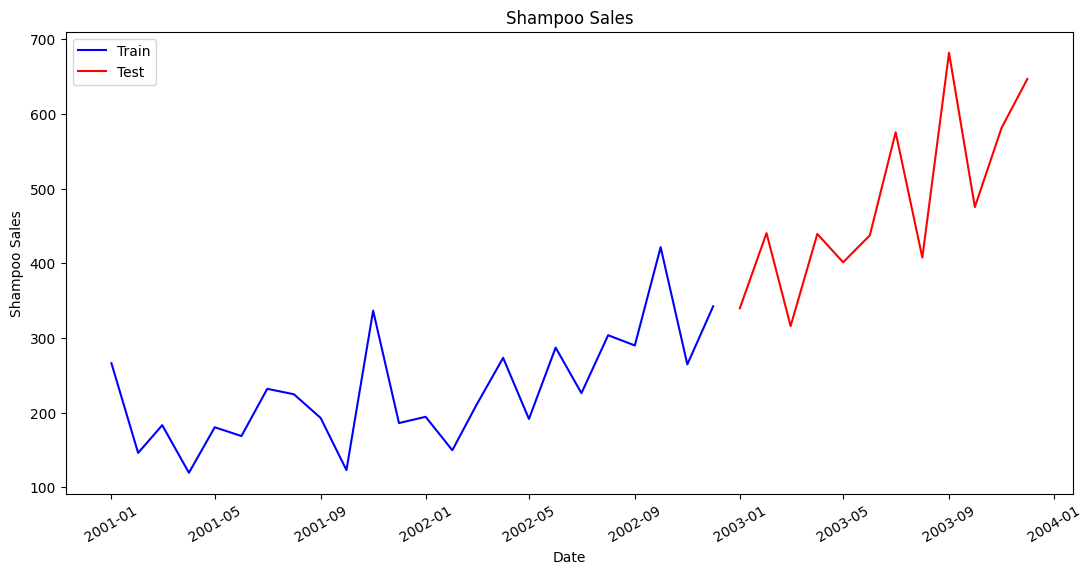

In [42]:
#@title Plotting Base Graph

plt.figure(figsize=(13, 6))
plt.plot(train_shampoo, color='blue')
plt.plot(test_shampoo, color='red')
plt.legend(['Train', 'Test'])
plt.xlabel('Date')
plt.ylabel('Shampoo Sales')
plt.xticks(rotation=30)
plt.title('Shampoo Sales')
plt.show()

In [43]:
#@title Checking ADF Statistic

shampoo_statistic = adfuller(dataset_shampoo['Sales of shampoo over a three year period'])
print('ADF Statistic:', shampoo_statistic[0])
print('p-value:', shampoo_statistic[1])

ADF Statistic: 3.060142083641181
p-value: 1.0


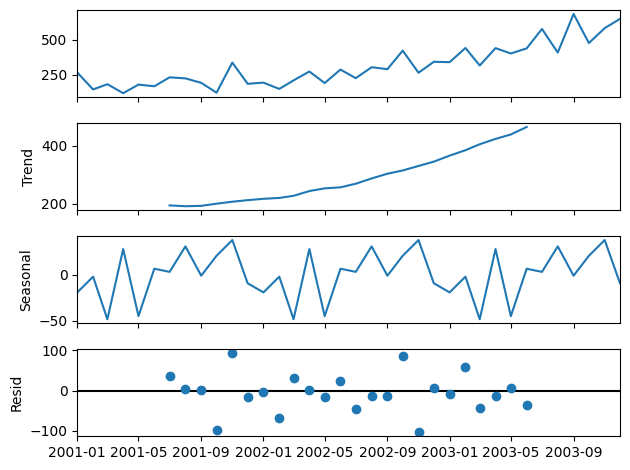

In [44]:
#@title Seasonal Decomposing

shampoo_seasonal_decompose = seasonal_decompose(dataset_shampoo, model='additive', period=12)
shampoo_seasonal_decompose.plot()
plt.show()

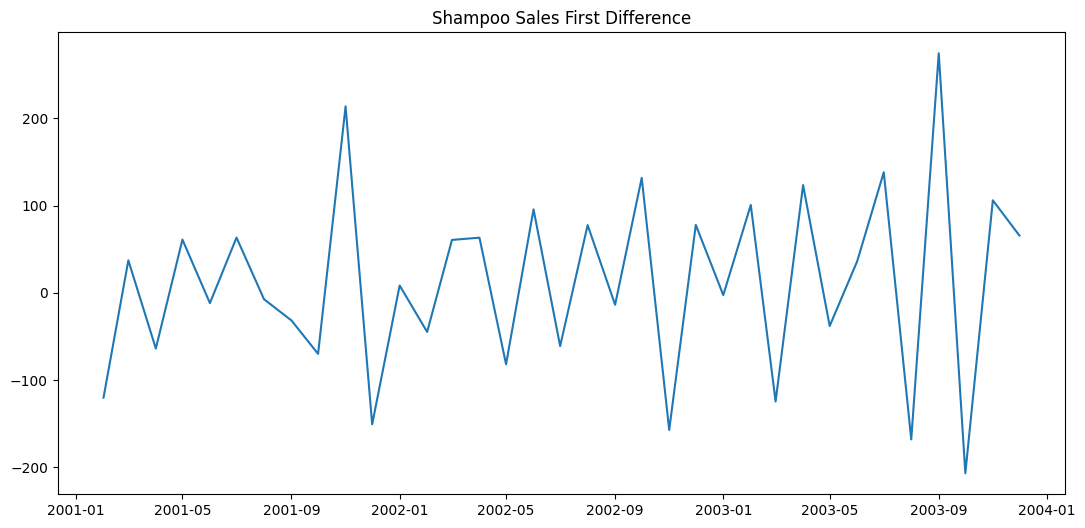

ADF Statistic: -7.249074055553854
p-value: 1.7998574141687034e-10


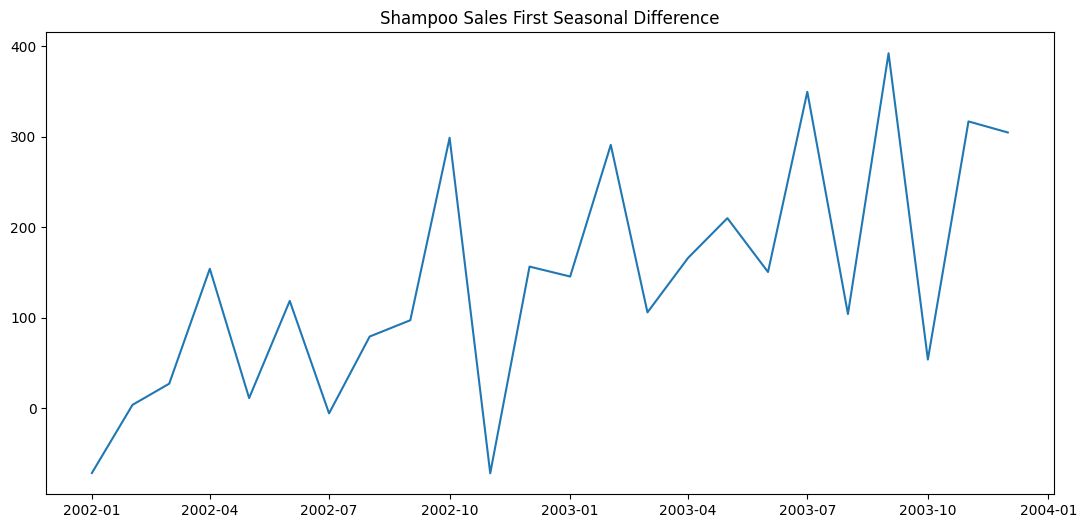

ADF Statistic: -0.04561553414248971
p-value: 0.9545931714075299


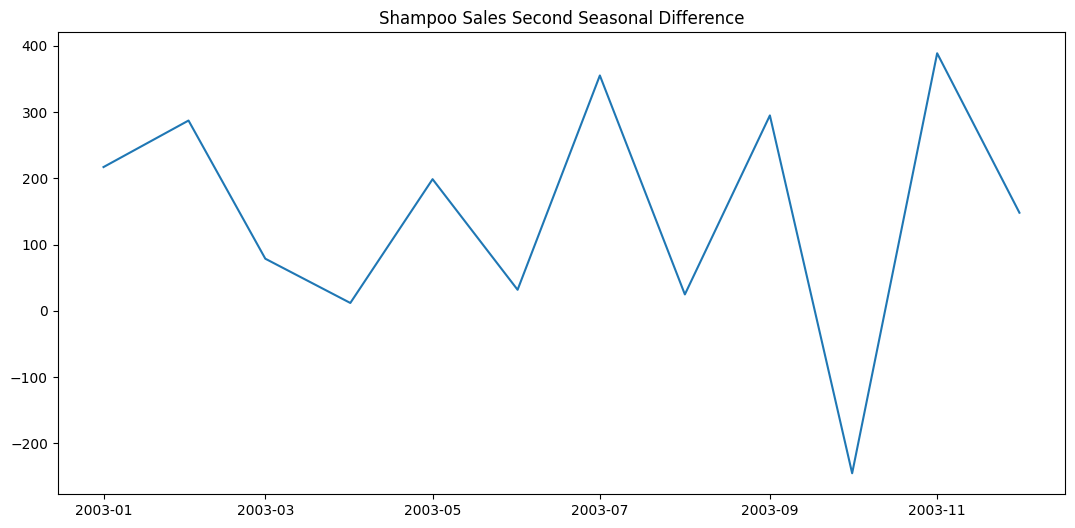

ADF Statistic: -1.6518072821420309
p-value: 0.4560980446452554


In [45]:
#@title Data Differencing

#First differencing
shampoo_first_diff = dataset_shampoo.diff().dropna()
plt.figure(figsize=(13, 6))
plt.plot(shampoo_first_diff)
plt.title('Shampoo Sales First Difference')
plt.show()

shampoo_first_diff_statistic = adfuller(shampoo_first_diff)
print('ADF Statistic:', shampoo_first_diff_statistic[0])
print('p-value:', shampoo_first_diff_statistic[1])

#Seasonal first differencing
shampoo_first_seasonal_diff = dataset_shampoo.diff(periods=12).dropna()
plt.figure(figsize=(13, 6))
plt.plot(shampoo_first_seasonal_diff)
plt.title('Shampoo Sales First Seasonal Difference')
plt.show()

shampoo_first_seasonal_diff_statistic = adfuller(shampoo_first_seasonal_diff)
print('ADF Statistic:', shampoo_first_seasonal_diff_statistic[0])
print('p-value:', shampoo_first_seasonal_diff_statistic[1])

#Seasonal Second differencing
shampoo_second_seasonal_diff = shampoo_first_seasonal_diff.diff(periods=12).dropna()
plt.figure(figsize=(13, 6))
plt.plot(shampoo_second_seasonal_diff)
plt.title('Shampoo Sales Second Seasonal Difference')
plt.show()

shampoo_second_seasonal_diff_statistic = adfuller(shampoo_second_seasonal_diff)
print('ADF Statistic:', shampoo_second_seasonal_diff_statistic[0])
print('p-value:', shampoo_second_seasonal_diff_statistic[1])

In [46]:
#@title Checking ADF Statistic After Differencing

# shampoo_statistic = adfuller(shampoo_first_diff)
# print('ADF Statistic:', shampoo_statistic[0])
# print('p-value:', shampoo_statistic[1])

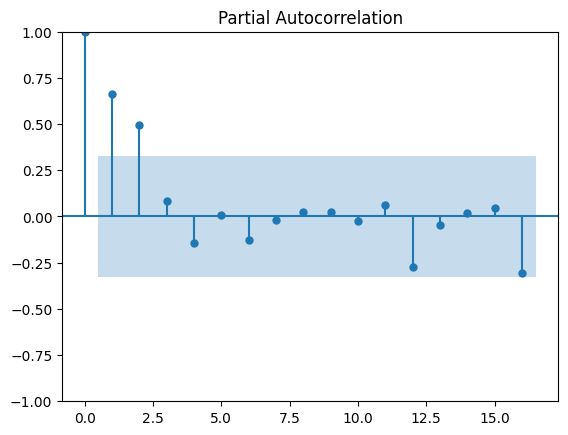

p =  2


In [47]:
#@title Plotting PACF

plot_pacf(dataset_shampoo)
plt.show()

shampoo_pacf_df = pacf(dataset_shampoo)

for i in range(0, len(shampoo_pacf_df)):
  if shampoo_pacf_df[i] < 1.96 / np.sqrt(len(dataset_shampoo)):
    print('p = ', i - 1)
    break

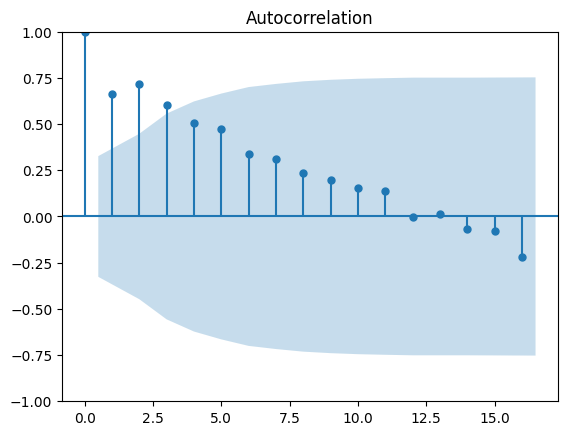

p =  6


In [48]:
#@title Plotting ACF

plot_acf(dataset_shampoo, fft=True)
plt.show()

shampoo_acf_df = acf(dataset_shampoo, fft=True)

for i in range(0, len(shampoo_acf_df)):
  if shampoo_acf_df[i] < 1.96 / np.sqrt(len(dataset_shampoo)):
    print('p = ', i - 1)
    break

The result show that dataset is non-stationary (p-value is not less than 0.05) and it have seasonal look from seasonal graph.

After differencing it still non-stationary, so I will using SARIMA Model.

## SARIMA Model

In [118]:
#@title Building Model

# shampoo_sarima = SARIMAX(train_shampoo, order=(2, 1, 6), seasonal_order=(2, 2, 2, 12))
shampoo_sarima = SARIMAX(train_shampoo, order=(4, 1, 2), seasonal_order=(4, 0, 2, 12), trend='ct')
shampoo_sarima = shampoo_sarima.fit()

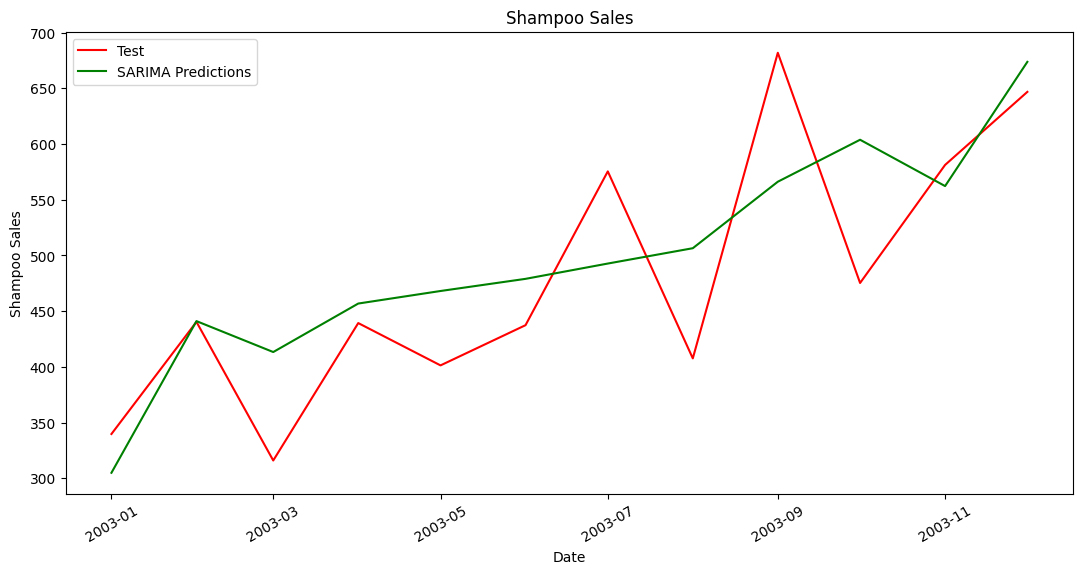

In [119]:
#@title Prediction

pred_shampoo_sarima = shampoo_sarima.get_forecast(steps=len(test_shampoo.index))
pred_shampoo_sarima_df = pred_shampoo_sarima.conf_int(alpha=0.05)
pred_shampoo_sarima_df['Predictions'] = shampoo_sarima.predict(start=pred_shampoo_sarima_df.index[0], end=pred_shampoo_sarima_df.index[-1])
pred_shampoo_sarima_df.index = test_shampoo.index

plt.figure(figsize=(13, 6))
# plt.plot(train_shampoo, color='blue')
plt.plot(test_shampoo, color='red')
plt.plot(pred_shampoo_sarima_df['Predictions'], color='green')
plt.legend(['Test', 'SARIMA Predictions'])
# plt.legend(['Train', 'Test', 'SARIMA Predictions'])
plt.xlabel('Date')
plt.ylabel('Shampoo Sales')
plt.xticks(rotation=30)
plt.title('Shampoo Sales')
plt.show()

In [120]:
#@title Evaluate

shampoo_sarima_rmse = np.sqrt(mean_squared_error(test_shampoo['Sales of shampoo over a three year period'], pred_shampoo_sarima_df['Predictions']))
print('SARIMA MODEL RMSE:', shampoo_sarima_rmse)

SARIMA MODEL RMSE: 73.52161130889483


# Experiment on Auto Hypertuning

## Using Mango

In [52]:
#@title Tune ARMA Parameters

# def arma_objective_function(args_list):
#   params_evaluated = []
#   results = []

#   for params in args_list:
#     try:
#       p, d, q = params['p'], params['d'], params['q']

#       model = SARIMAX(train_temperature, order=(p,d,q))
#       predictions = model.fit()

#       rmse = np.sqrt(mean_squared_error(train_temperature, predictions.fittedvalues))
#       params_evaluated.append(params)
#       results.append(rmse)
#     except:
#       #print(f"Exception raised for {params}")
#       #pass
#       params_evaluated.append(params)
#       results.append(1e5)

#       #print(params_evaluated, rmse)
#   return params_evaluated, results

# param_space = dict(
#   p = range(0, 10),
#   d = range(0, 10),
#   q = range(0, 10),
# )

# conf_Dict = dict()
# conf_Dict['num_iteration'] = 200
# data_values = list(train_temperature['Daily minimum temperatures'])
# tuner = Tuner(param_space, arma_objective_function, conf_Dict)
# results = tuner.minimize()
# print('best parameters:', results['best_params'])
# print('best loss:', results['best_objective'])

In [53]:
#@title Tune ARIMA Parameters

# def arima_objective_function(args_list):
#   params_evaluated = []
#   results = []

#   for params in args_list:
#     try:
#       p, d, q = params['p'], params['d'], params['q']
#       trend = params['trend']

#       model = ARIMA(train_temperature, order=(p,d,q), trend=trend)
#       predictions = model.fit()

#       rmse = np.sqrt(mean_squared_error(train_temperature, predictions.fittedvalues))
#       params_evaluated.append(params)
#       results.append(rmse)
#     except:
#       #print(f"Exception raised for {params}")
#       #pass
#       params_evaluated.append(params)
#       results.append(1e5)

#       #print(params_evaluated, rmse)
#   return params_evaluated, results

# param_space = dict(
#   p = range(0, 10),
#   d = range(0, 10),
#   q = range(0, 10),
#   trend = ['n', 'c', 't', 'ct']
# )

# conf_Dict = dict()
# conf_Dict['num_iteration'] = 200
# data_values = list(train_temperature['Daily minimum temperatures'])
# tuner = Tuner(param_space, arima_objective_function, conf_Dict)
# results = tuner.minimize()
# print('best parameters:', results['best_params'])
# print('best loss:', results['best_objective'])

In [96]:
#@title Tune SARIMA Parameters

def sarima_objective_function(args_list):
  params_evaluated = []
  results = []

  for params in args_list:
    try:
      p, d, q = params['p'], params['d'], params['q']
      P, D, Q, S = params['P'], params['D'], params['Q'], params['S']
      trend = params['trend']

      model = SARIMAX(train_shampoo, order=(p, d, q), seasonal_order=(P, D, Q, S), trend=trend)
      predictions = model.fit()

      rmse = np.sqrt(mean_squared_error(train_shampoo, predictions.fittedvalues))
      params_evaluated.append(params)
      results.append(rmse)
    except:
      #print(f"Exception raised for {params}")
      #pass
      params_evaluated.append(params)
      results.append(1e5)

      #print(params_evaluated, rmse)
  return params_evaluated, results

param_space = dict(
  p = range(0, 5),
  d = range(0, 5),
  q = range(0, 5),
  P = range(0, 5),
  D = range(0, 5),
  Q = range(0, 5),
  S = [12],
  trend = ['n', 'c', 't', 'ct']
)

conf_Dict = dict()
conf_Dict['num_iteration'] = 200
data_values = list(train_shampoo['Sales of shampoo over a three year period'])
tuner = Tuner(param_space, sarima_objective_function, conf_Dict)
results = tuner.minimize()
print('best parameters:', results['best_params'])
print('best loss:', results['best_objective'])

  0%|          | 0/200 [00:00<?, ?it/s]

best parameters: {'D': 0, 'P': 4, 'Q': 2, 'S': 12, 'd': 0, 'p': 4, 'q': 2, 'trend': 'ct'}
best loss: 47.119127713826096


## Using Auto ARIMA

In [58]:
results = pm.auto_arima(
    train_shampoo,
    d=2,
    start_p=1,
    start_q=1,
    max_p=8,
    max_q=8,
    seasonal=True,
    m=12,
    D=1,
    start_P=1,
    start_Q=1,
    max_P=8,
    max_Q=8,
    information_criterion='aic',
    trace=True,
    error_action='ignore',
    stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,1,1)[12]             : AIC=inf, Time=0.56 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=145.214, Time=0.03 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(0,2,0)(1,1,0)[12]             : AIC=inf, Time=0.62 sec
 ARIMA(0,2,0)(0,1,1)[12]             : AIC=inf, Time=0.34 sec
 ARIMA(0,2,0)(1,1,1)[12]             : AIC=148.272, Time=1.04 sec
 ARIMA(1,2,0)(0,1,0)[12]             : AIC=inf, Time=0.10 sec
 ARIMA(0,2,1)(0,1,0)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(1,2,1)(0,1,0)[12]             : AIC=133.515, Time=0.31 sec
 ARIMA(1,2,1)(1,1,0)[12]             : AIC=inf, Time=1.16 sec
 ARIMA(1,2,1)(0,1,1)[12]             : AIC=inf, Time=1.05 sec
 ARIMA(2,2,1)(0,1,0)[12]             : AIC=135.512, Time=0.27 sec
 ARIMA(1,2,2)(0,1,0)[12]             : AIC=inf, Time=0.61 sec
 ARIMA(0,2,2)(0,1,0)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(2,2,